# Couple channel model - using Kelvin

In this notebook we will create a simple ocean-atmosphere system in a 1D channel. The two media are coupled through heat fluxes, but there is no exchange of momentum (could be added) as both are advected with pre-determined velocities. The governing equations for the atmospheric and the oceaning temperatures are

\begin{equation}
\frac{\partial T_a}{\partial t} = -u_a \frac{\partial T_a}{\partial x} + D_a\frac{\partial^2 T_a}{\partial x^2} +  \frac{F}{H_a \cdot C_{pa} \cdot \rho_a} - \frac{\alpha \epsilon T_a^4}{H_a \cdot C_{pa} \cdot \rho_a}
\end{equation}

\begin{equation}
\frac{\partial T_o}{\partial t}  = -u_o \frac{\partial T_o}{\partial x} + D_o\frac{\partial^2 T_o}{\partial x^2} - \frac{F}{H \cdot C_{po} \cdot \rho_o} + \frac{T_{AW}-T_o}{\tau} + \frac{F_{SW}}{H \cdot C_{po} \cdot \rho_o}
\end{equation}

and they are coupled through net heat flux term $F$

\begin{equation}
F=F_0+r_a \cdot C_{pa} \cdot v_a \cdot C_s \cdot (T_o-T_a)
\end{equation}

where $F_0$ is forcing term which is used to drive the model. This system lacks the latent heat flux which is why $C_s$ is taken to be 3E-3 i.e. three times higher than the conventional value 1E-3.

At the boundary we take the ocean and atmospheric temperatures to be in an equilibrium, there is no advection or diffusion, but the boundary temperature feels the radiative fluxes and is restored to 20C on an annual timescale.

### FIRST RESULTS

Does addition of more than one section add to the predictability - using all lags/sections does, not when using sections and the same lag?? Try to find a combination which would give better results than any of the individual ones!!

test the following:

1) no atm advection
2) variable ocean/atm advection speed
3) longer NAO like record

More realistic ice would require keeping track of the temperature of ice - maybe too much of a hassle.

Slab ocean leads to high correlation at multiple lags throughout the region, because it responds to exactly the same forcing as the sea ice - the impact of the atmosphere is small.

The fully coupled system provides a distinct timescale that is limited by the ocean advection.



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LogNorm, SymLogNorm, from_levels_and_colors
from scipy import signal
import coupled_channel.cutils as cutils
import os
import sys
from coupled_channel.surrogates import Surrogates

## FORCING

In [2]:
#forcings
#nao=np.loadtxt('norm.nao.monthly.b5001.current.ascii.table')[:-1,-1]; dt_f=30*24*3600 #66 years of monthly NAO
nao0 = np.loadtxt('../data/raw/norm.daily.nao.index.b500101.current.ascii')[:,-1]; dt_f=24*3600 #66 yeas of daily NAO
#
nao_surrogate    = Surrogates(np.tile(nao0[:50*360,np.newaxis],22).T)
nao_s = nao_surrogate.refined_AAFT_surrogates(np.tile(nao0[:50*360,np.newaxis],22).T,10).flatten().squeeze()
nao_s = -2*(0.5-(nao_s - np.min(nao_s,0))/np.max((nao_s - np.min(nao_s,0)),0))
#
nao_white=1-2*np.random.rand(len(nao_s))
#

Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


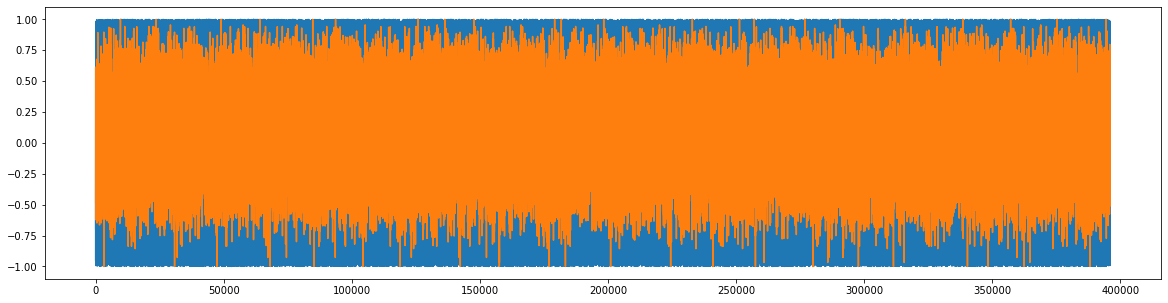

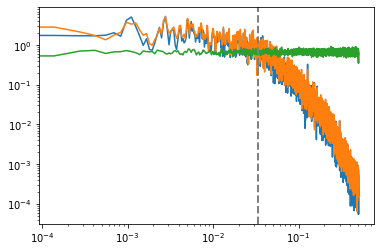

In [3]:
plt.figure(figsize=(20,5))
#
plt.plot(nao_white)
plt.plot(nao_s)
#
plt.figure()
f0,p0 = signal.welch(-2*(0.5-(nao0 - np.min(nao0,0))/np.max((nao0 - np.min(nao0,0)),0)),fs=1,nperseg=20*360)
f1,p1 = signal.welch(nao_s,fs=1,nperseg=20*360)
f2,p2 = signal.welch(nao_white,fs=1,nperseg=20*360)
plt.loglog(f0,p0)
plt.loglog(f1,p1)
plt.loglog(f2,p2)
plt.axvline(x=1/30,lw=2,ls='--',color='gray')

## SETUP

In [4]:
#spatial_pattern = 5.*np.sin(np.arange(C['nx'])*np.pi/(C['nx']/2.))
#
#tmax = 66*360*24*3600 # calculate 30-year timeseries
tmax = (len(nao_s)-1*360.)*dt_f
#
avep = 30*24*3600. #seconds - daily
T0   = 273.15+20
# combination of 50E3 grid cells and 30 grid cells will give 1500 km basin
xx   = 50.E3
nx   = 40
dt   = 3600. # one hour time step is convenient
#
spatial_pattern=100.*np.ones(nx) #+10*np.random.rand(nx)
#
dT = 0.
period = 2*360*24*3600.
#
SW0 = 160.-1.*np.arange(nx)
SW_anom = 160.
#
Cs = 3.E-3
Da = 1.E5
#
Do = 1.E2
tau_entrainment = 4*360*24*3600.
#
forcing = nao_s #None #100*nao
forcing_str = 'synthetic_nao_random_spatial'
ice_model=True
atm_adv=True
#

## EXAMPLE  1 - CONTROL CLIMATE

In [9]:
H=50.
va=5.
args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
# first run a control case for 10 years without any time-variable forcing
tmax=1*360*24*3600
args['tmax']=tmax
C    = cutils.set_model_constants(**args)
forcing = None


In [6]:
np.sum((np.ones(2),np.ones(2),np.ones(2)),axis=0)

array([3., 3.])

In [6]:
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)


Year  1.0 279.73005979530825 278.87576737450786
Year  2.0 275.55166661195165 272.86288695721123
Year  3.0 274.7019271558007 271.6107638494162
Year  4.0 274.5276917650988 271.35936239121025
Year  5.0 274.49190601084376 271.35000149386104
Year  6.0 274.48455356028126 271.3500001899152
Year  7.0 274.4830428385747 271.35000080947884
Year  8.0 274.4827324233054 271.35000096621076
Year  9.0 274.48266864059445 271.35000056873713
Year  10.0 274.48265553480974 271.35000129237085
CPU times: user 17.4 s, sys: 60 ms, total: 17.5 s
Wall time: 17.5 s


In [10]:
%time tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt12, nt2, atm_DA_tendencies2, ocn_DA_tendencies2 = cutils.CoupledChannel2(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function sum at 0x7f19c00ec430>) found for signature:
 
 >>> sum(UniTuple(array(float64, 1d, C) x 2), axis=Literal[int](0))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'sum': File: numba/core/typing/npydecl.py: Line 348.
        With argument(s): '(UniTuple(array(float64, 1d, C) x 2), axis=Literal[int](0))':
       No match.

During: resolving callee type: Function(<function sum at 0x7f19c00ec430>)
During: typing of call at /home/aleksi/Documents/NORCE/code/coupled_channel/coupled_channel/cutils.py (112)


File "../coupled_channel/cutils.py", line 112:
def CoupledChannel_time(nt,nx,xx,dt,avep,sst,tas,hice,sst_boundary,sst_out,tas_out,hice_out,sflx_f_out,sflx_out,forcing,spatial_pattern,ra,Cp,va,vo,Da,Do,Cs,T0,Tf,emissivity,SW0,SW_anom,H,Hb,Cpo,ro,tau_entrainment,Li,ri,use_ocn_tendencies,use_atm_tendencies, atm_DA_tendencies, ocn_DA_tendencies,ice_model,atm_adv,return_coupled_fluxes):
    <source elided>
        if return_coupled_fluxes:
            atm_DA_tendencies[nn,:]=np.sum((a_adv,a_diff),axis=0)
            ^


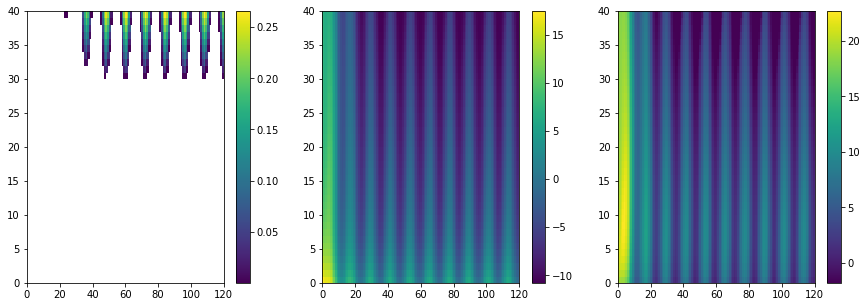

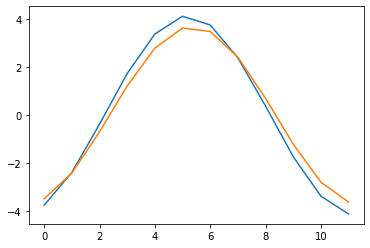

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15)
#
plt.colorbar(mappable=cm1,ax=ax1)
plt.colorbar(mappable=cm2,ax=ax2)
plt.colorbar(mappable=cm3,ax=ax3)
#
plt.figure()
plt.plot(sst_out[-360*24*3600//C['avep']:,5]-np.nanmean(sst_out[-360*24*3600//C['avep']:,5]))
plt.plot(sst_out[-360*24*3600//C['avep']:,25]-np.nanmean(sst_out[-360*24*3600//C['avep']:,25]))

## EXAMPLE - SLAB OCEAN

Show that by diagnosing the fluxes we can replicate the same control climate

In [178]:
H=50
va=5
args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
# first run a control case for 10 years without any time-variable forcing
tmax=20*360*24*3600
args['tmax']=tmax
C    = cutils.set_model_constants(**args)
forcing = None
tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
# then run a 100 case without a time-variable forcing, but input the DA tendencies from the previous case 
atm_DA_tendencies2 = atm_DA_tendencies[-360*24*3600//C['dt']:]
ocn_DA_tendencies2 = ocn_DA_tendencies[-360*24*3600//C['dt']:]
tmax=100*360*24*3600
args['tmax']=tmax
C    = cutils.set_model_constants(**args)
tas_out_slab, sst_out_slab, hice_out_slab, sflx_out_slab, sflx_f_out_slab, nt1, nt = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2,atm_DA_tendencies=atm_DA_tendencies2)
#

293.15 [160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143
 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125
 124 123 122 121] 100000.0 50000.0
0.9942079222359147
293.15 294.14420792223586
Year  1.0 279.73005979552414 278.8757544550712
Year  2.0 275.55166661195165 272.86288695721373
Year  3.0 274.7019271558007 271.6107638494162
Year  4.0 274.5276917650988 271.35936239121025
Year  5.0 274.49190601084376 271.35000149386104
Year  6.0 274.48455356028126 271.3500001899152
Year  7.0 274.4830428385747 271.35000080947884
Year  8.0 274.4827324233054 271.35000096621076
Year  9.0 274.48266864059445 271.35000056873713
Year  10.0 274.48265553480974 271.35000129237085
Year  11.0 274.4826528418891 271.35000015829127
Year  12.0 274.48265228856206 271.3500007127731
Year  13.0 274.4826521748649 271.35000053263286
Year  14.0 274.4826521515046 271.35000049562024
Year  15.0 274.482652146702 271.3500004880129
Year  16.0 274.4826521457154 271.3500004864484
Year  17

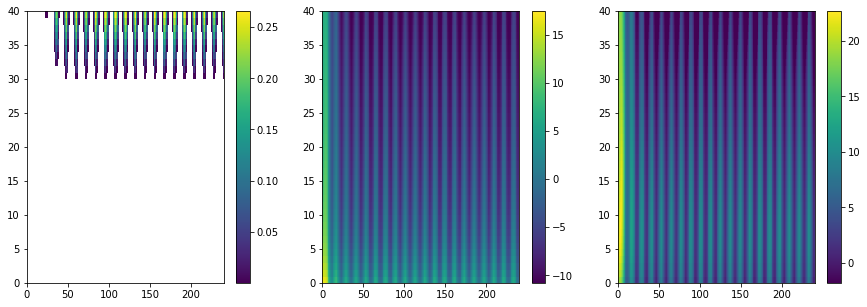

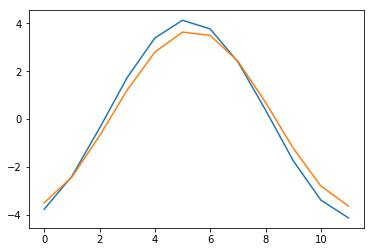

In [180]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15)
#
plt.colorbar(mappable=cm1,ax=ax1)
plt.colorbar(mappable=cm2,ax=ax2)
plt.colorbar(mappable=cm3,ax=ax3)
#
plt.figure()
plt.plot(sst_out[-360*24*3600//C['avep']:,5]-np.nanmean(sst_out[-360*24*3600//C['avep']:,5]))
plt.plot(sst_out[-360*24*3600//C['avep']:,25]-np.nanmean(sst_out[-360*24*3600//C['avep']:,25]))

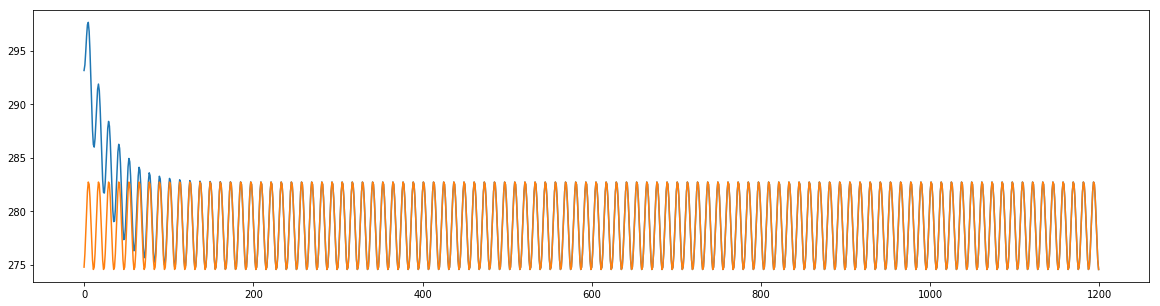

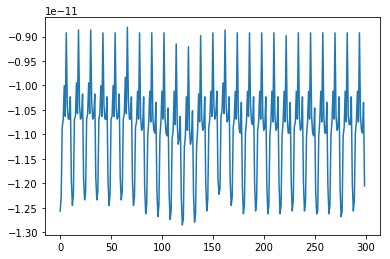

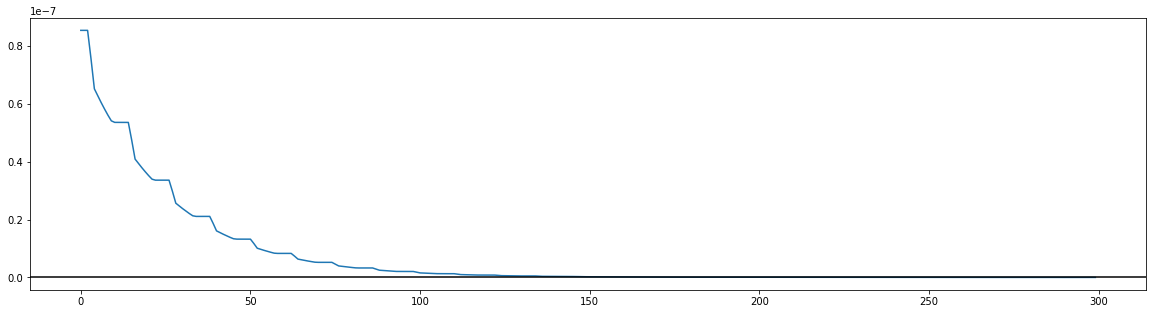

In [186]:
plt.figure(figsize=(20,5))
plt.plot(sst_out_slab[:,10])
plt.plot(np.tile(sst_out[-360*24*3600//C['avep']:,10],100))
#
plt.figure()
plt.plot(sst_out_slab[-25*360*24*3600//C['avep']:,10]-np.tile(sst_out[-360*24*3600//C['avep']:,10],100)[-25*360*24*3600//C['avep']:])
#plt.plot()
#
plt.figure(figsize=(20,5))
plt.plot((sst_out_slab[:,-1]-np.tile(sst_out[-360*24*3600//C['avep']:,-1],100))[-25*360*24*3600//C['avep']:])
plt.axhline(y=0,color='k')

## PRODUCTION CASE

In [7]:
# RUN THE MODEL
data={}
for nf_str,nao in enumerate([nao_s,nao_white]):
    if nf_str==0:
        forcing_str = 'synthetic_nao_random_spatial'
    elif nf_str==1:
        forcing_str = 'white_noise_nao_random_spatial'
    #
    for H in [50]: #,100,200]:
        for va in [5]: #,10,15]:
            #print(H,va)
            #if os.path.exists('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz'):
            #    print('case exists - loading...')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
            #    print('done!')
            #else:
                tmax = 50*360*24*3600
                args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
                # first run a control case for 10 years without any forcing
                C    = cutils.set_model_constants(**args)
                forcing = None
                tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
                atm_DA_tendencies2 = atm_DA_tendencies[-360*24*3600//C['dt']:]
                ocn_DA_tendencies2 = ocn_DA_tendencies[-360*24*3600//C['dt']:]
                # then run a fully coupled case with varying forcing
                forcing = nao
                tmax    = (len(nao)-1*360)*dt_f
                args['tmax'] = tmax
                C = cutils.set_model_constants(**args)
                #
                tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)
                # then run a slab ocean case (i.e. ocean advection and diffusion tendencies from the control case)
                tas_out1, sst_out1, hice_out1, sflx_out1, sflx_f_out1, nt1_1, nt1 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2)
                # then run a slab_atm (i.e. atm advection and diffusion tendencies from the control case)
                tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt1_2, nt2 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ocn_mixing_ratio=0, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,atm_DA_tendencies=atm_DA_tendencies2)
                #Save the data
                #
                print('saving the data...')
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz',tas_out=tas_out0, sst_out=sst_out0, hice_out=hice_out0, sflx_out=sflx_out0, sflx_f_out=sflx_f_out0,nt1=nt1_0,nt=nt0,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz',tas_out=tas_out1, sst_out=sst_out1, hice_out=hice_out1, sflx_out=sflx_out1, sflx_f_out=sflx_f_out1,nt1=nt1_1,nt=nt1,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz',tas_out=tas_out2, sst_out=sst_out2, hice_out=hice_out2, sflx_out=sflx_out2, sflx_f_out=sflx_f_out2,nt1=nt1_2,nt=nt2,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                #
                #load the same data
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
        #

293.15 [160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143
 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125
 124 123 122 121] 100000.0 50000.0
0.9654210260279585
293.15 294.11542102602795
Year  1.0 279.7300597948741 278.87574551433653
Year  2.0 275.55166661195165 272.8628869571969
Year  3.0 274.7019271558007 271.6107638494162
Year  4.0 274.5276917650988 271.35936239121025
Year  5.0 274.49190601084376 271.35000149386104
Year  6.0 274.48455356028126 271.3500001899152
Year  7.0 274.4830428385747 271.35000080947884
Year  8.0 274.4827324233054 271.35000096621076
Year  9.0 274.48266864059445 271.35000056873713
Year  10.0 274.48265553480974 271.35000129237085
Year  11.0 274.4826528418891 271.35000015829127
Year  12.0 274.48265228856206 271.3500007127731
Year  13.0 274.4826521748649 271.35000053263286
Year  14.0 274.4826521515046 271.35000049562024
Year  15.0 274.482652146702 271.3500004880129
Year  16.0 274.4826521457154 271.3500004864484
Year  17.